In [1]:
import tensorflow as tf
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

In [2]:
!wget http://storage.googleapis.com/ibeans/train.zip
!wget http://storage.googleapis.com/ibeans/validation.zip
!wget http://storage.googleapis.com/ibeans/test.zip

--2024-02-20 07:16:55--  http://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  16.5MB/s    in 9.9s    

2024-02-20 07:17:07 (13.8 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2024-02-20 07:17:07--  http://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================

In [3]:
!mkdir beans

In [4]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [ ]:
!ls beans

test  train  validation


In [ ]:
!find beans -type f | wc -l

1296


In [ ]:
!find beans/test -type f | wc -l

128


In [ ]:
!find beans/train -type f | wc -l

1035


In [ ]:
!find beans/validation -type f | wc -l

133


In [ ]:
display(Image("/content/beans/test/healthy/healthy_test.0.jpg"))

In [5]:
batch_size = 64
image_height = 224
image_width = 224

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("beans/train",
  seed = 111,
  image_size = (image_height, image_width),
  batch_size = batch_size
)

Found 1034 files belonging to 3 classes.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory("beans/test",
  seed = 111,
  image_size = (image_height, image_width),
  batch_size = batch_size
)

Found 128 files belonging to 3 classes.


In [7]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory("beans/validation",
  seed = 111,
  image_size = (image_height, image_width),
  batch_size = batch_size
)

Found 133 files belonging to 3 classes.


In [9]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [10]:
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


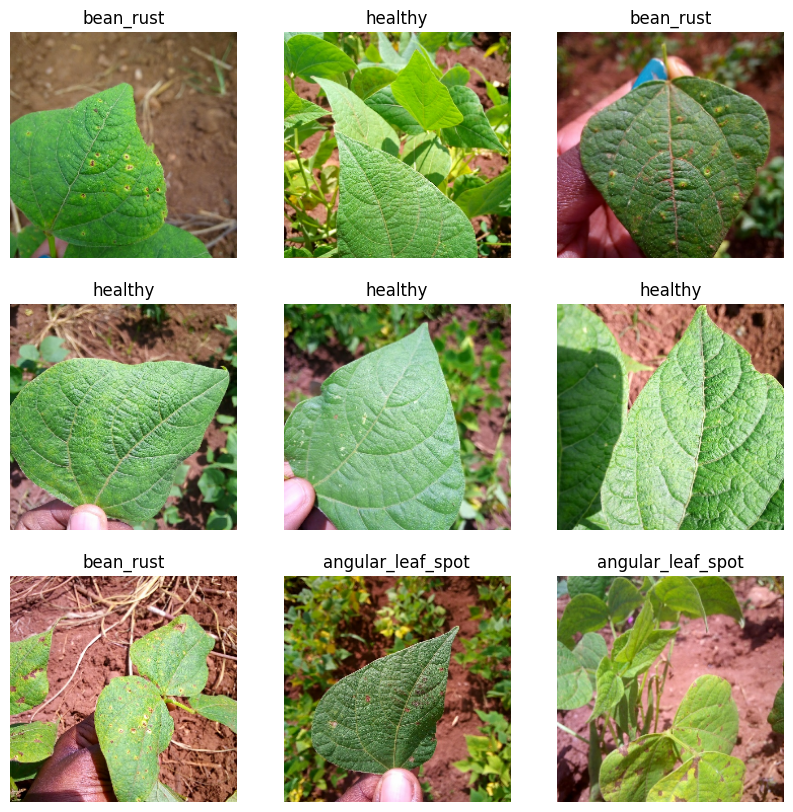

In [11]:
plt.figure(figsize = (10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
feature_extractor = "http://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [14]:
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape = (image_height, image_width,3))

In [15]:
feature_extractor_layer.trainable = False

In [16]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
tf.random.set_seed(111)

In [18]:
model = tf.keras.Sequential([
    normalization_layer,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation = "softmax")
])

In [19]:
model.compile(
    optimizer = "adam",
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [20]:
history = model.fit(train_ds, epochs = 15, validation_data = val_ds)

Epoch 1/15
17/17 [==============================] - 14s 236ms/step - loss: 1.0132 - accuracy: 0.5116 - val_loss: 0.6229 - val_accuracy: 0.7368
Epoch 2/15
17/17 [==============================] - 1s 79ms/step - loss: 0.6717 - accuracy: 0.7099 - val_loss: 0.4728 - val_accuracy: 0.7895
Epoch 3/15
17/17 [==============================] - 1s 79ms/step - loss: 0.5417 - accuracy: 0.7592 - val_loss: 0.4061 - val_accuracy: 0.8421
Epoch 4/15
17/17 [==============================] - 1s 79ms/step - loss: 0.4623 - accuracy: 0.8153 - val_loss: 0.3681 - val_accuracy: 0.8571
Epoch 5/15
17/17 [==============================] - 1s 82ms/step - loss: 0.4134 - accuracy: 0.8317 - val_loss: 0.3460 - val_accuracy: 0.8496
Epoch 6/15
17/17 [==============================] - 1s 82ms/step - loss: 0.3663 - accuracy: 0.8491 - val_loss: 0.3259 - val_accuracy: 0.8421
Epoch 7/15
17/17 [==============================] - 1s 79ms/step - loss: 0.3335 - accuracy: 0.8820 - val_loss: 0.3116 - val_accuracy: 0.8647
Epoch 8/15


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


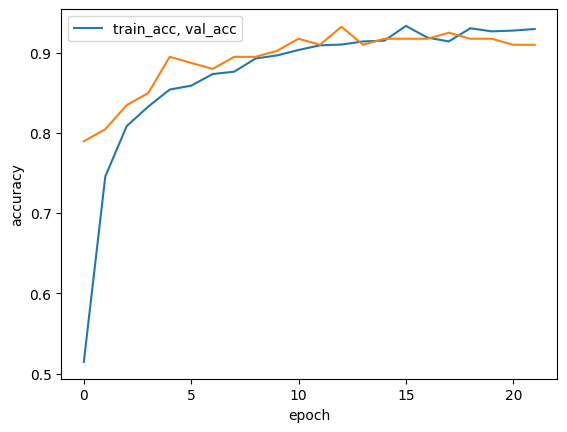

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.legend(['train_acc, val_acc'], loc = "best")
plt.show()

In [ ]:
result = model.evaluate(test_ds)

2/2 [==============================] - 0s 95ms/step - loss: 0.2624 - accuracy: 0.9141


AttributeError: module 'keras.api._v2.keras.preprocessing.image' has no attribute 'image_to_array'

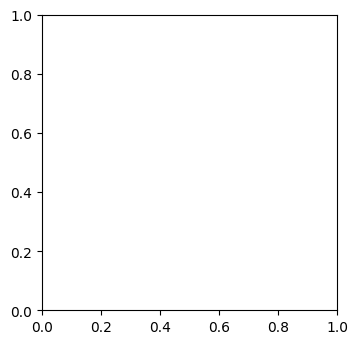

In [21]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.tight_layout()
    img = tf.keras.preprocessing.image.image_to_array(images[i])
    img = np.expand_dims(img,axis = 0)
    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual label: %s" % classes [labels[i]])
    plt.text(1, 240, "Prediction label: %s" % classes[np.argmax(pred)], fontsize = 12)
    plt.axis("off")

In [22]:
model.save("./models", save_format = "tf")

In [ ]:
!ls models

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [23]:
model_loaded = tf.keras.models.load_model("./models/")

In [ ]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [24]:
from skimage import transform
from PIL import Image
def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype("float32")
  np_image = transform.resize(np_image, (224,224,3))
  np_image = np.expand_dims(np_image, axis = 0)
  return np_image

In [25]:
pred_label = model_loaded.predict(process("/content/beans/train/healthy/healthy_train.0.jpg"))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 2s 2s/step
healthy


In [ ]:
pred_label

array([[1.5291754e-04, 1.9670997e-02, 9.8017615e-01]], dtype=float32)

In [26]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/fingerprint.pb (stored 0%)


In [27]:
print(tf.__version__)

2.15.0
